## Deep Learning on Satellite Images

* While we continue on our goal of creating a model to predict GDP of a country using Satellite Images, first thing we do is to build baseline models. 
  - We will use these baseline models as reference points to compare our final model to

* Goal of this notebook is to document creation and evaluation of baseline models
* We will try to build 
  - Mean Prediction model
  - Deep Learning model

* After creating the models we will graphically look at how well the model is performing on the Test set


Firstly let's load the required libraries.

In [ ]:
import matplotlib.pyplot as plt
import pathlib
import os

### Downloading Dataset

Below we basically setup kaggle to be able to load the required dataset using kaggle cli.

Follow [this](https://www.kaggle.com/general/51898) to get your own username and kaggle key 

In [ ]:
!pip install kaggle
os.environ['KAGGLE_USERNAME'] = "svaidehi"
os.environ['KAGGLE_KEY'] = "40631027d1c9b560ca2ba5753d23ad11"

Let's download the dataset from [here](https://kaggle.com/abhijeetdtu/country-nightlight-dataset)

In [ ]:
!kaggle datasets download -d abhijeetdtu/country-nightlight-dataset

 99% 681M/685M [00:02<00:00, 241MB/s]
100% 685M/685M [00:02<00:00, 245MB/s]


Now we unzip the dataset

In [ ]:
import zipfile

In [ ]:
if not os.path.exists("dataset"):
  for file in os.listdir():
    if file.find(".zip") > -1:
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

Now let's git clone our helper code

In [ ]:
!git clone https://github.com/abhijeetdtu/dsba4152

fatal: destination path 'dsba4152' already exists and is not an empty directory.


In [ ]:
%ls

country-nightlight-dataset.zip  dataset/   gdp_melted.csv  README.md
data_c/                         dsba4152/  preview/        reports/


In [ ]:
%cd dsba4152

/content/dsba4152/dsba4152


In [ ]:
#if you need lastest code
#!git fetch origin master

In [ ]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from dsba4152.utils.get_test_train import GetTestTrain

### Data Load and Preprocessing

Let's setup the root path where our dataset of images is and where our csv which has our y labels.

Then we use our helper function we just imported to load all the images and their corresponding labels. The helper method also returns other metadata including `year` of the image and `country code` of the image as well. This information is used later on.

In [ ]:
root_path = "../dataset/dataset/"
csv_path = "../gdp_melted.csv"
X , y , years , code = GetTestTrain(root_path , csv_path , resize=True , resize_shape=(256,256)).get_all_data()

Let's look at a few images we have just loaded.

In [ ]:
imgdf = pd.DataFrame({ "gdp" : y , "year" : years}).reset_index()
imgdf["year"].unique()

array([2002, 2009, 2000, 1996, 2008, 2007, 2005, 1993, 2010, 2011, 2001,
       2003, 2006, 1992, 1997, 2004, 1999, 1998])

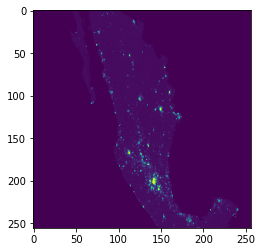

In [ ]:
plt.imshow(X[imgdf[imgdf["year"] == 2006].head(1)["index"].values[0]])

## Trick and Treat !

Okay so here is something different that we are going to try before we throw the data into the model. 

Even though deep learning models do feature extraction, but if we think we can help why not ?

The idea we are going to follow is

1. Select a base reference image , possibly from one of the earliest years (1993)
2. Divide the intensities of the reference image into bins
3. Bin every other image based on the bins obtained from the reference image
4. After binning the image, we keep values that are above a threshold (that we find using hit and try)

What this helps us achieve is - make all images relative to the base image. This in turn helps the model in determining which image is brighter than the base image and therefore help with the predictions. 

Let's look at 3 images, each being a decade apart from the previous one.

In [ ]:
im1993 = X[imgdf[imgdf["year"] == 1993].head(1)["index"].values[0]]
im2003 = X[imgdf[imgdf["year"] == 2003].head(1)["index"].values[0]]
im2011 = X[imgdf[imgdf["year"] == 2011].head(1)["index"].values[0]]

refyear = imgdf["year"].unique()[0]
refimg = X[imgdf[imgdf["year"] == refyear].head(1)["index"].values[0]]
space =  np.geomspace(0.5,1,1000)
bins = np.quantile(refimg ,space)

def thresh(im , t=970):
    g = np.digitize(im , bins)
    return np.where(g > t , im , 0)

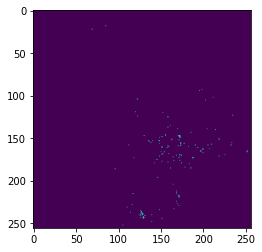

In [ ]:
plt.imshow(thresh(im1993 , 990))

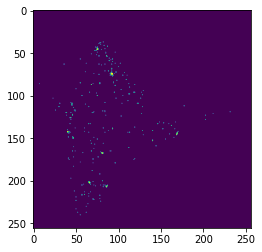

In [ ]:
plt.imshow(thresh(im2003 , 990))

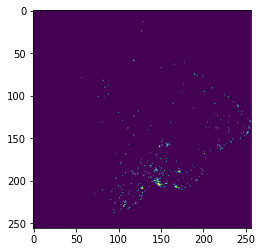

In [ ]:
plt.imshow(thresh(im2011 , 990))

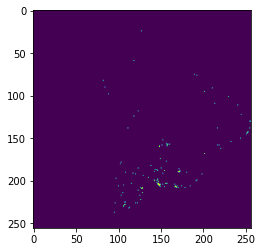

In [ ]:
plt.imshow(thresh(im2011 , 995))

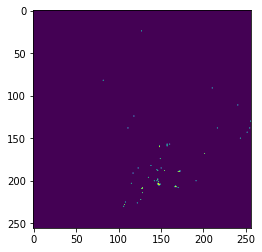

In [ ]:
plt.imshow(thresh(im2011 , 997))

Let's apply the trick to all our images.

Another thing that we have to do is to add a new axis to our image dataset because `Keras` expects input data to be in a specific format - (batch_size , height , width , number_of channels).

Since we have only one channel, simply using `np.newaxis` helps.

In [ ]:
import cv2

#X50 = np.array([cv2.resize(im ,(128,128) ,cv2.INTER_CUBIC) for im in X])
X50 = X.copy()
X50 = X50[..., np.newaxis]
#X50 = thresh(X50 , 990)

#X50 = X50 / np.max(X50)
X50 = X50 / 255.
# X50_970 = thresh(X50 , 970)
# X50_980 = thresh(X50 , 980)
# X50_990 =  thresh(X50 , 990)

# X50 = np.stack([X50_970 , X50_980 , X50_990] , axis=3)

#X50 = np.repeat(X50[..., np.newaxis], 3, -1)

input_shape = X50.shape
input_shape

(2667, 256, 256, 1)

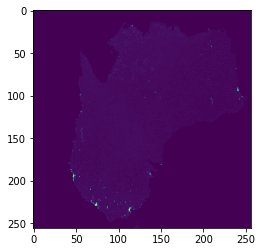

In [ ]:
plt.imshow(X50[400,:,:,0])

### Mixed Data Model

SO instead of just feeding in the image and trying to predict the GDP numbers we will provide more information to our model. This information will be the original `size of the country` and the `year` of the image.

This would mean that our model takes both image and numerical information as input and predicts the GDP

<center>

![im](https://pyimagesearch.com/wp-content/uploads/2019/02/keras_multi_input_mixed_data.png)

</center>

To achieve this we load in country size and year information for each row in our data.

In [ ]:
size_df  =pd.DataFrame([(f.split("_")[0] , f) for f in os.listdir(root_path)] , columns=["code" , "path"]).drop_duplicates("code")

def getshape(p):
  s = plt.imread(root_path + p).shape
  return np.array(s)

shapes = size_df["path"].apply(getshape)
size_df[["hc" , "wc"]] = np.array(list(shapes.values)) / input_shape[1]

y_size_df = pd.DataFrame({"code" : code}).set_index("code").join(size_df.set_index("code")).reset_index()
y_size_df["compfactor"] = y_size_df["hc"] + y_size_df["wc"] 
y_size_df["year"] = years

In [ ]:
size_x = y_size_df[["hc" , "wc" , "year"]].apply(lambda c : (c - c.mean()) / c.std())
size_x

,hc,wc,year
0,0.635997,0.118569,-0.036245
1,0.635997,0.118569,-0.036245
2,0.635997,0.118569,-0.036245
3,0.635997,0.118569,-0.036245
4,0.635997,0.118569,-0.036245
...,...,...,...
2662,0.966520,7.212057,-1.823033
2663,0.966520,7.212057,-1.823033
2664,0.966520,7.212057,-1.823033
2665,0.966520,7.212057,-1.823033


`hc` = height compression
`wc` = width compression
`year` = year of the image.

We have also scaled all these variables using a `MinMax` scaler.


Now Let's split the data to get training and test sets.

One thing that we take care of here is to `stratify`. This is because we want our training and testing data to have similar number of images belonging to each year.


In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train, y_test = train_test_split(X50 , y , stratify = years)

In [ ]:
train_idx = y_train.index
test_idx = y_test.index
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [ ]:
X_size_train , X_size_test = size_x.iloc[train_idx , :] , size_x.iloc[test_idx , :]

In [ ]:
np.mean(y_train)

1472850076544.7065

In [ ]:
np.median(y_train)

782241000000.0

Below we scale the `gdp` values. This is crucial because it pushes everything to a managable range which prevents the gradient in the neural network from becoming too small or too large ([vanishing or exploding gradient problem](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/))

In [ ]:
ss = StandardScaler()
y_train = ss.fit_transform(y_train)
y_test = ss.transform(y_test)

## Let's get funky!

Now that we have everything setup! Let's get to modeling.

Our final model will be a mixed data model. Let's look at the architecture.

![image](https://user-images.githubusercontent.com/6872080/99859984-bac08a00-2b5f-11eb-8e84-3eaac51ab663.png)

Let's get building this in Keras



In [ ]:
from keras.models import Sequential
from keras.layers import Dense , MaxPooling2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Conv2D
import keras.backend as K
from keras.metrics import RootMeanSquaredError
from keras import layers
import keras
from keras.applications.vgg16 import VGG16

Below we build a simple `multi layer perceptron` for our *numerical* inputs

In [ ]:
def create_mlp(dim):
  # define our MLP network
  model = Sequential()
  model.add(Dense(8, input_dim=dim, activation="relu"))
  model.add(Dense(4, activation="relu"))
  # check to see if the regression node should be added
  #model.add(Dense(1, activation="linear"))
  # return our model
  return model

Below we build a `CNN` model for our *image* input

In [ ]:
def create_cnn(input_shape):

  #model = VGG16(include_top=False, input_shape=input_shape[1:])
  # conv_base = VGG16(include_top=False, input_shape=input_shape[1:])
  # for layer in conv_base.layers:
  #   layer.trainable = False

  model = Sequential()
  #model.add(conv_base)
  model.add(Conv2D(256, 3, input_shape=input_shape[1:]))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(128
                          , kernel_size=3
                          , strides=2
                          , padding="same"
                          , kernel_regularizer=keras.regularizers.L1(0.025)))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(64
                          , kernel_size=3
                          , strides=2
                          , padding="same"
                          , kernel_regularizer=keras.regularizers.L1(0.025)))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(64))
  model.add(layers.LeakyReLU(alpha=0.2))
  #model.add(Dense(1, kernel_initializer='normal', activation="linear"))

  return model

In [ ]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Now let's combine both these two models together by adding a dense layer and then our final prediction layer with just 1 unit and `linear` activation

In [ ]:
mlp = create_mlp(size_x.shape[1])
cnn = create_cnn(input_shape)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(64, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_3_input (InputLayer)     [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 254, 254, 256 2560        conv2d_3_input[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 254, 254, 256 0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 254, 254, 256 0           leaky_re_lu_4[0][0]              
_______________________________________________________________________________________

### Let's Grab coffee

Time to train the network and grab a coffee perhaps.

We are using `Mean Absolute Error` as the loss function and `RMSE` as a metric.

We use `Adam` optimizer with a `learning rate` of `1e-3`.
`Batch Size` is set to 16 and number of `epochs` is 30

In [ ]:
opt = Adam(lr=1e-3)
model.compile(loss="mean_absolute_error", optimizer=opt , metrics=[RootMeanSquaredError(name='rmse')])
# train the model
model.fit(
	x=[size_x.iloc[train_idx , :].values, X_train], y=y_train,
	validation_data=([size_x.iloc[test_idx , :].values, X_test], y_test),
	epochs=30, batch_size=16)

Epoch 1/30
125/125 [==============================] - 58s 461ms/step - loss: 34.4393 - rmse: 0.9094 - val_loss: 1.4683 - val_rmse: 0.4188
Epoch 2/30
125/125 [==============================] - 57s 455ms/step - loss: 1.4114 - rmse: 0.4176 - val_loss: 1.3158 - val_rmse: 0.2927
Epoch 3/30
125/125 [==============================] - 57s 454ms/step - loss: 1.2956 - rmse: 0.3035 - val_loss: 1.2916 - val_rmse: 0.2892
Epoch 4/30
125/125 [==============================] - 57s 455ms/step - loss: 1.2530 - rmse: 0.2641 - val_loss: 1.2476 - val_rmse: 0.2344
Epoch 5/30
125/125 [==============================] - 57s 454ms/step - loss: 1.2236 - rmse: 0.2281 - val_loss: 1.2080 - val_rmse: 0.2079
Epoch 6/30
125/125 [==============================] - 57s 455ms/step - loss: 1.2157 - rmse: 0.2225 - val_loss: 1.2202 - val_rmse: 0.2134
Epoch 7/30
125/125 [==============================] - 57s 454ms/step - loss: 1.2037 - rmse: 0.2076 - val_loss: 1.2031 - val_rmse: 0.2079
Epoch 8/30
125/125 [====================

### Visualizing the learnt filters

Before we look at how well our model is performing, what has our model learnt really ? 

We can get a glimpse of that by peaking into the filters that the model has learnt.

Let's look at the `7th Conv2d` layer filters


In [ ]:
filters, biases = cnn.layers[7].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
filters.shape

(3, 3, 128, 64)

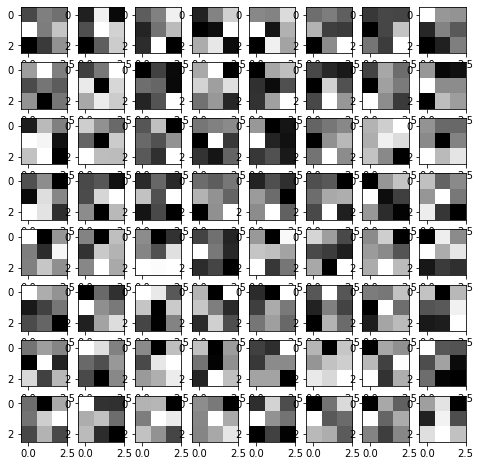

In [ ]:
n_filters, ix = filters.shape[-1], 1
r , c = 8, 8
fig , axs = plt.subplots(r,c, figsize=(8,8))
fig.set
for i in range(n_filters):
  # get the filter
  f = filters[:, :, 0, i]
  ax = axs[int(i/c)][i%c]
  # plot filter channel in grayscale
  ax.imshow(f[:, :], cmap='gray')
	
plt.show()

It seems like the model is learning filters that are separating out lit up regions from the darker/unlit regions. 


### Feature Map visualization

Now that we have looked at the learnt filters, let's look at the activations for a particular input image. This would give a sense of what exactly the model is focusing on to make the predictions.

In [ ]:
from keras.models import Model
feature_model = Model(inputs=cnn.inputs, outputs=cnn.layers[7].output)

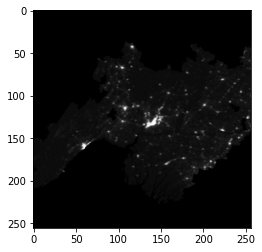

In [ ]:
img = np.expand_dims(X50[500], axis=0)
plt.imshow(img[0,  : , : , 0] , cmap='gray')

In [ ]:
img.shape

(1, 256, 256, 1)

In [ ]:
feature_maps = feature_model.predict(img)
feature_maps.shape

(1, 64, 64, 64)

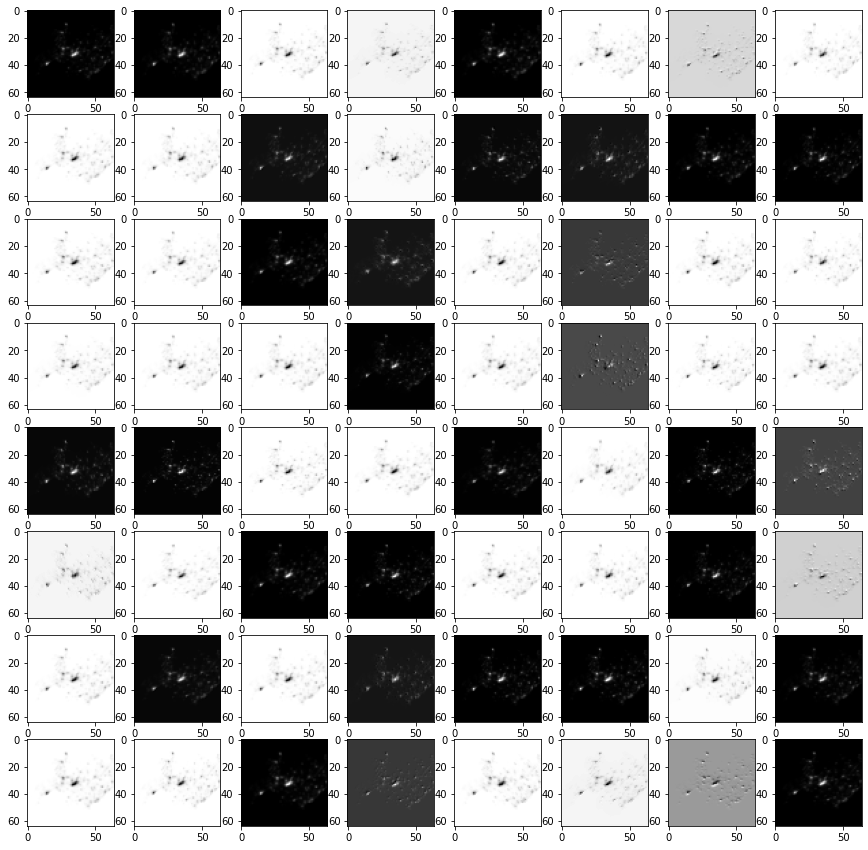

In [ ]:
n_filters, ix = feature_maps.shape[-1], 1
fig , axs = plt.subplots(8,8, figsize=(15,15))
fig.set
for i in range(n_filters):
  # get the filter
  f = feature_maps[0, :, :, i]
  ax = axs[int(i/8)][i%8]
  # plot filter channel in grayscale
  ax.imshow(f, cmap='gray')
	
plt.show()

Looking at some of the feature maps we can see that the activations are happening in the lit up regions. 

Interestingly one of the feature map appears to be segmenting the country out of the image.

Now that we have visually looked at how our model is working, let's quantitatively evaluate the performance.

### Error Metrics and Comparisions

We will use `RMSE` below on the `train` and `test` sets to evaluate the performance.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
def mae_ru(y_true , y_pred):
  y_true = ss.inverse_transform(y_true)
  y_pred = ss.inverse_transform(y_pred)
  return mean_absolute_error(y_true,y_pred)

In [ ]:
def rmse_ru(y_true, y_pred):
  y_true = ss.inverse_transform(y_true)
  y_pred = ss.inverse_transform(y_pred)
  return np.sqrt(mean_squared_error(y_true,y_pred))

In [ ]:
mae_ru(y_train , model.predict([X_size_train, X_train]))

90605105429.2245

In [ ]:
rmse_ru(y_train , model.predict([X_size_train, X_train]))

149261776283.4082

Train set MAE - $112B

Train set RMSE - $156B


In [ ]:
mae_ru(y_test , model.predict([X_size_test, X_test]))

131945218989.96101

131945218989.96101

In [ ]:
rmse_ru(y_test , model.predict([X_size_test, X_test]))

Test set MAE - $131B

Test set RMSE - $188B

In [ ]:
max_gdp = ss.inverse_transform(np.max(y_test).reshape(-1,1))[0][0]
max_gdp

7551500000000.0

In [ ]:
mean_gdp = ss.inverse_transform(np.mean(y_test).reshape(-1,1))[0][0]
mean_gdp

1517968041815.61

### Mean Predictor Performance

Now let's compare our model with a very simple `Mean/Median` Predictor.

In [ ]:
rmse_ru(y_train , np.repeat(np.median(y) , y_train.shape[0]))

1.3261410608834807e+24

In [ ]:
rmse_ru(y_train , np.repeat(np.mean(y) , y_train.shape[0]))

2.516067002670875e+24

`1e+24` that's very poor performance! Our `CNN` model does so much better!

### Model Debugging

To further improve our model we need to first figure out where it's performing poorly.

Few areas that we want to do a deeper dive on are
1. Compression
  - Since we are resizing the images, larger countries undergo larger compression which might potentially lead to poorer performance for these countries
2. Years
  - It is also possible that since more recent images are brighter than image, say from 1993 , we might see poor performance on those early years and therefore might want to investigate the results.


To visually look into these 2 areas, we do a scatter plot of the `predicted` values vs the `ground truth` and `fill` depending on either the `compression` or `years`.

First let's get the compression values for each country.

In [ ]:
size_df  =pd.DataFrame([(f.split("_")[0] , f) for f in os.listdir(root_path)] , columns=["code" , "path"]).drop_duplicates("code")

def getshape(p):
  s = plt.imread(root_path + p).shape
  return np.array(s)

shapes = size_df["path"].apply(getshape)

In [ ]:
size_df[["hc" , "wc"]] = np.array(list(shapes.values)) / 128

In [ ]:
size_df

,code,path,hc,wc
0,MEX,MEX_2002.png_0_286.jpeg,17.796875,29.687500
1,BRA,BRA_2009.png_0_2423.jpeg,39.664062,38.429688
2,JPN,JPN_2002.png_0_5015.jpeg,18.695312,25.750000
4,BGD,BGD_2009.png_0_3194.jpeg,6.101562,5.570312
8,IND,IND_2007.png_0_848.jpeg,28.851562,29.664062
10,CHN,CHN_1993.png_0_885.jpeg,34.234375,61.757812
12,AUS,AUS_2010.png_0_4798.jpeg,32.445312,43.304688
70,RUS,RUS_1992.png_0_4580.jpeg,36.031250,337.507812


We can see that larger countries like `Russia` experience huge compression, especially on its width. Whereas smaller countries like 'Bangladesh' experience relatively smaller compression.

In [ ]:
y_size_df = pd.DataFrame({"code" : code}).set_index("code").join(size_df.set_index("code")).reset_index()
y_size_df["compfactor"] = y_size_df["hc"] + y_size_df["wc"] 
y_size_df

,code,path,hc,wc,compfactor
0,AUS,AUS_2010.png_0_4798.jpeg,32.445312,43.304688,75.750000
1,AUS,AUS_2010.png_0_4798.jpeg,32.445312,43.304688,75.750000
2,AUS,AUS_2010.png_0_4798.jpeg,32.445312,43.304688,75.750000
3,AUS,AUS_2010.png_0_4798.jpeg,32.445312,43.304688,75.750000
4,AUS,AUS_2010.png_0_4798.jpeg,32.445312,43.304688,75.750000
...,...,...,...,...,...
2662,RUS,RUS_1992.png_0_4580.jpeg,36.031250,337.507812,373.539062
2663,RUS,RUS_1992.png_0_4580.jpeg,36.031250,337.507812,373.539062
2664,RUS,RUS_1992.png_0_4580.jpeg,36.031250,337.507812,373.539062
2665,RUS,RUS_1992.png_0_4580.jpeg,36.031250,337.507812,373.539062


In [ ]:
from plotnine import *

mt = theme(panel_grid_major=element_line(alpha=0.2 , color="#3d405b") 
          , panel_grid_minor=element_blank() 
          , panel_background=element_rect(fill="#f4f1de"))

In [ ]:
def plotcomp(X,y,comp):
  perfdf = pd.DataFrame({"ytrue" : ss.inverse_transform(y)[:, 0] 
                       , "ypred" :  ss.inverse_transform(model.predict(X).reshape(-1,1))[:,0] 
                       ,"comp" : comp})
  
  p = (
    ggplot(perfdf , aes(x="ytrue" , y="ypred" , fill="comp")) 
    + geom_point(stroke=0 , alpha=0.8)
    + annotate('segment',x=0,y=0,xend= 7e12 , yend=7e12 , alpha=0.2)
    + scale_y_continuous(breaks=np.arange(500e9 , 10e12, 2e12) , labels=[f"{v}T" for v in np.arange(0.5, 10 , 2)])
    + scale_x_continuous(breaks=np.arange(500e9 , 10e12, 2e12) , labels=[f"{v}T" for v in np.arange(0.5, 10 , 2)])
  )
  return p + mt

def plot(X,y,idx):
  comp = y_size_df.iloc[idx , :]["compfactor"]
  return plotcomp(X,y,comp)
  

Let's first look at how compression effects our predictions on the `training` set.

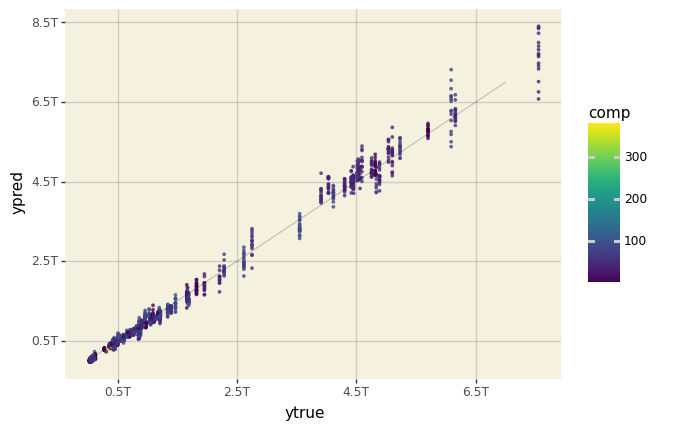

<ggplot: (-9223363306226328060)>

In [ ]:
plot([X_size_train , X_train],y_train , train_idx)

We see that our predictions are pretty close to the actual values.

\[NOTE EDIT]: Before we had applied regularization:

We were seeing perfectly aligned predictions and ground truths for our training set, which indicates that our model might be overfitting the training set. Therefore one thing we will follow up on is to reduce this overfitting.

Now let's look at the test set.

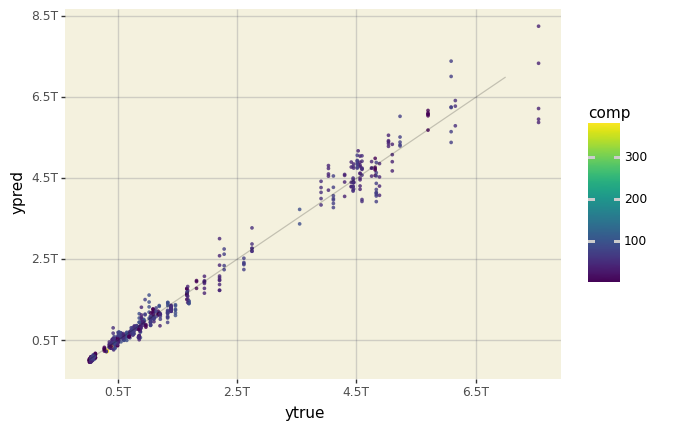

<ggplot: (-9223363307257956590)>

In [ ]:
plot([X_size_test , X_test],y_test ,test_idx)

We see that even though our model had overfit the training set, the test set performance is not too bad, specially on when looking at highly compressed countries like `Russia` and `China`. We do see poor performance for China (top right corner) where our model is under-predicting the GDP values.

But for `Russia` (lower left yellow dots), it seems that the model is performing better than expected.

Now let's directly look at the predictions colored by the country.

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


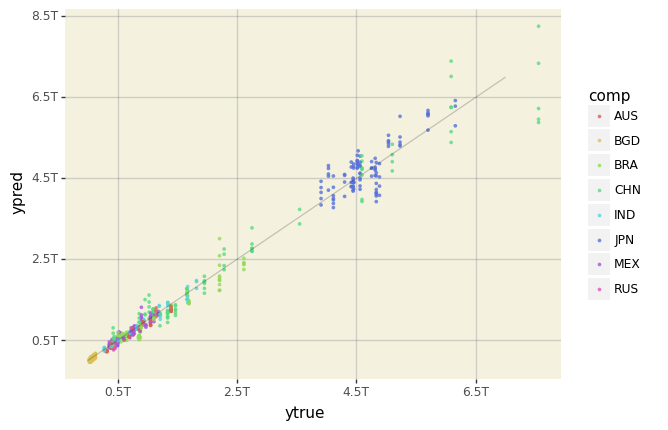

<ggplot: (-9223363307258530602)>

In [ ]:
plotcomp([X_size_test , X_test],y_test ,code[test_idx])

Now Let's move to year.

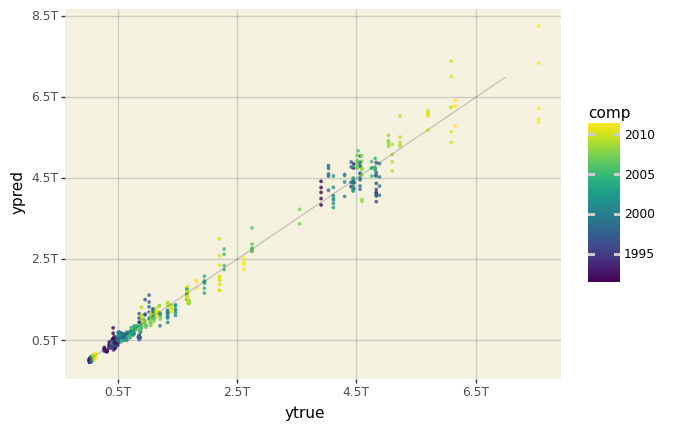

<ggplot: (-9223363307258525920)>

In [ ]:
plotcomp([X_size_test , X_test],y_test ,years[test_idx])

### Next Steps

Next steps for us would be 
1. To reduce overfitting
2. To reduce impact of Compression (resizing)
3. To perform Shapley Analysis of the model
4. Subnational test dataset


Appendix:

#### How to handle different sized images

1. [SemScholar](https://www.semanticscholar.org/paper/Attention-to-Scale%3A-Scale-Aware-Semantic-Image-Chen-Yang/9f48616039cb21903132528c0be5348b3019db50?p2df)
  - We can feed the same image multiple times to the network, but with varying scales each time, and then take the average of the results.
  - This might only work if we start with images of the same aspect ratio, which would defeat the purpose.

2. [Arxiv](https://arxiv.org/pdf/1411.4038.pdf)
  - We could make the network fully-convolutional, meaning it has convolutional, max-pooling, and batch normalization layers all of which are invariant to the size of the image.

3. [StackExch](https://datascience.stackexchange.com/questions/40462/how-to-prepare-the-varied-size-input-in-cnn-prediction)
  - Resize the images to the size of the smallest images (OpenCV, PIL), but we would lose some details.
  - Alternatively, we could pad the images of unequal sizes to a desired size, but resizing images is simpler.

4. [StackExch](https://stats.stackexchange.com/questions/250258/can-a-convolutional-neural-network-take-as-input-images-of-different-sizes)
  - Im2markup and other architectures do not assume that all images have the same dimension.

5. [Arxiv](https://arxiv.org/abs/1312.4400)
  - Pool the output of the last convolutional layer in a way that yields a fixed size array.

6. [Medium](https://medium.com/neuronio/how-to-deal-with-image-resizing-in-deep-learning-e5177fad7d89)
  -Explains why upscaling is a worse solution to down scaling
What if we downed scaled large images and upscaled small images


- Global Max-Pooling
- Padding to a certain size

w/ Keras:
-Will not be able to flatten layers. Will need GlobalMaxPooling2D or GlobalAveragePooling2D. (adaptivemaxpool2d) -> fastai
    -Can not put different sizes in a single numpy array.
   	 -This means we will
   		 1) Resize groups of the same size without big variations to ease training
   		 2) Do not resize and train images one by one
   		 3) Keep aspect ratio and pad sides of images.
   			 -May be easier since we are looking at light intensities.

In [ ]:
model.save('11_20_2020_mixed_data')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: 11_20_2020_mixed_data/assets


In [ ]:
model.save("11_20_2020_mixed_data.h5")

In [ ]:
model

In [ ]:
!pip install shap
import shap

In [ ]:
X_train.shape

(2000, 256, 256, 1)

In [ ]:

# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 10, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
#e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])

NameError: ignored

In [ ]:
background.shape

(100, 256, 256, 1)

In [ ]:
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)